In [1]:
# core scientific libraries
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr
import datetime

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# secondary libraries
import netCDF4 as nc
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords, interplevel, CoordPair, vertcross, g_uvmet, interpline, destagger,
                interp2dxy, ll_to_xy, xy, ALL_TIMES, vinterp)
import metpy.calc as mpcalc
from metpy.units import units

import pytz

from xarray.backends.netCDF4_ import NetCDF4DataStore

import copy 

In [2]:
def plot_cross_section(data, pot_data, terrian, levels_data, levels_pot, data_cols, data_units, data_title, \
                       data_name, outdir, lines_lat, lines_col, y_max, mnt_labels, mnt_labs_pos):
    ''' plot cross section'''
    
    # save vertical and horizontal coordinates
    vert = data['z'].sel(z = slice(0, y_max))
    hor = data['lat']
    
    # Start Figure
    fig = plt.figure(figsize=(12, 6))

    # Specify plotting axis (single panel)
    ax = plt.subplot(111)

    cf = ax.contourf(hor, vert, data.sel(z = slice(0, y_max))[:,:,0].values, cmap = data_cols, \
                         extend = 'both', levels = levels_data)

    # Theta contours 
    theta_contours = ax.contour(hor, vert, pot_data.sel(z = slice(0, y_max))[:,:,0].values, colors = 'k', levels = levels_pot)

    plt.clabel(theta_contours, fmt='%d',fontsize=8.5, inline_spacing=5, inline = 1)

    ct = ax.fill_between(hor, 0, terrian[:,0].values, facecolor = "silver")

    cb = plt.colorbar(cf, ax=ax, label = data_units)
    
    ax.set_xlabel("Latitude along Longitude " + str(data['lon'][0].values), fontsize=12)
    ax.set_ylabel("Height (m)", fontsize=12)
    
    # add labels for SYM and SRM
    props = dict(facecolor='silver', edgecolor = 'silver')
    
    if (mnt_labels == True):
        # add labels for SYM and SRM
        props = dict(facecolor='silver', edgecolor = 'silver')

        ax.text(mnt_labs_pos[0], mnt_labs_pos[1], 'SYM', fontsize = 15, transform = ax.transAxes, bbox = props)
        ax.text(mnt_labs_pos[2], mnt_labs_pos[3], 'SRM', fontsize = 15, transform = ax.transAxes, bbox = props) 
    
    n_lines = len(lines_lat)
    
    for i in range(n_lines):
        plt.plot([lines_lat[i], lines_lat[i]], [0,y_max] , color = lines_col[i], linestyle = 'dashed')
    
    # Make title of datatime and second title for date time
    plt.title(data_title)
    plt.title(str(data['time'].values)[:16].replace('T',' ') + ' PDT', loc = 'right')
    
    # Display figure
    # save file name as start datetime end datetime and variable
    plot_name = data_name + '_' \
            + str(data['time'].values)[:13].replace('/','_').replace(' ','_').replace('T','_').replace('-','_') + \
                '.png'

    plt.savefig(outdir+plot_name,  bbox_inches='tight', dpi = 120)
    plt.show()
    print('File saved as:', outdir+plot_name, '\n')
    
    
def xsection_subplots(data, data_fill, terrian, levelstheta, levelswind, data_cols, data_units, data_title, data_name, \
                      outdir, width, height, spaces, nrows, ncols, des_hours, dur, title_y, cbar_y, multi_bar, y_max):
    
    """A function that plots hourly wrf cross sections in multiple subplots"""
    
    #  pull times from xarray
    timez = data['time'].values
    
    # save vertical and horizontal coordinates
    vert = data['z'].sel(z = slice(0, y_max))
    hor = data['lat']
    
    # create figure
    fig = plt.figure(figsize = (width, height))
    gs = plt.GridSpec(nrows, ncols, figure = fig, hspace = spaces[0], wspace = spaces[1])

    # loop through each subplot 
    d = 0
    
    for r in range(nrows):

        for c in range(ncols):

            k = des_hours[d]

            # add plot axes 
            ax = fig.add_subplot(gs[r,c])
            
            cf = ax.contourf(hor, vert, data_fill.sel(Time = k, z = slice(0, y_max))[:,:,0].values, cmap = data_cols, \
                                 extend = 'both', levels = levelswind)
            # Theta contours 
            theta_contours = ax.contour(hor, vert, data.sel(Time = k, z = slice(0, y_max))[:,:,0].values, \
                                        colors = 'k', levels = levelstheta)

            plt.clabel(theta_contours, fmt='%d',fontsize=8.5, inline_spacing=5, inline = 1)

            ct = ax.fill_between(hor, 0, terrian[:,0].values, facecolor = "silver")


            ax.set_xlabel("Latitude along Longitude " + str(data['lon'][0].values), fontsize=12)
            ax.set_ylabel("Height (m)", fontsize=12)

            # add subtitles for date time
            plt.title(str(timez[k])[:16].replace('T',' ') + ' PDT', loc = 'right')
            
            d = d + 1
            
            if (multi_bar == True):
                cb = plt.colorbar(cf,
                    orientation='horizontal', extendfrac='auto', label = data_units)
            
    # add data title for all of subplots
    fig.suptitle(data_title, fontsize = 14, x = 0.515, y = title_y)

    if (multi_bar == False):
        # add one colorbar to the bottom
        ax2 = fig.add_axes([0.25, cbar_y, 0.5, 0.002])
        cb = plt.colorbar(cf, cax=ax2,
                        orientation='horizontal', extendfrac='auto', label = data_units)

    # Display figure
    # save file name as start datetime end datetime and variable
    plot_name = data_name + '_' + str(timez[des_hours[0]])[:16].replace('/','_').replace(' ','_').\
                replace('T','_').replace(':','_') + '_to_' + str(timez[des_hours[dur - 1]])[:16].\
                replace('/','_').replace(' ','_'). replace('T','_').replace(':','_') + '.png'

    plt.savefig(outdir+plot_name,  bbox_inches='tight', dpi = 120)
    plt.show()
    print('File saved as:', outdir+plot_name, '\n')

In [3]:
# Set filepath
datdir = '../input_data/wrf_out_post/'
filename = 'wrfout_d03_2017-05-22_00:00:00_zlev'

# set output filepath
outdir = '/home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/plotting/outputs/'
fig_outdir = '/home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/plotting/outputs/figures/'
dat_outdir = '/home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/plotting/outputs/data/'


# open wrf Dataset object
filepath = datdir + filename
print('Opened File:', filepath, '\n')

# Open NetCDF Dataset object
data = xr.open_dataset(filepath)

Opened File: ../input_data/wrf_out_post/wrfout_d03_2017-05-22_00:00:00_zlev 



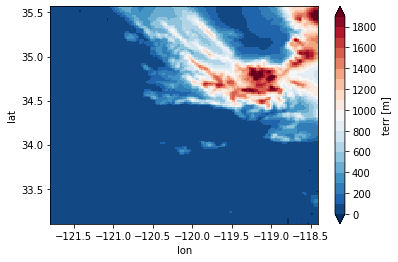

In [7]:
data['terr'].plot(levels = np.arange(0, 2000, 100))

In [18]:
# choose cross section starting and ending lat and lons
cross_lats = [34.9, 33.9]
cross_lons = [-119.65, -119.66] # must only include one longitude point

# save thetas, vertical velocities, topo heights, and pbl height through the cross section
cross_data = data.sel(lat = slice(cross_lats[1], cross_lats[0]), 
                     lon = slice(cross_lons[1], cross_lons[0]))

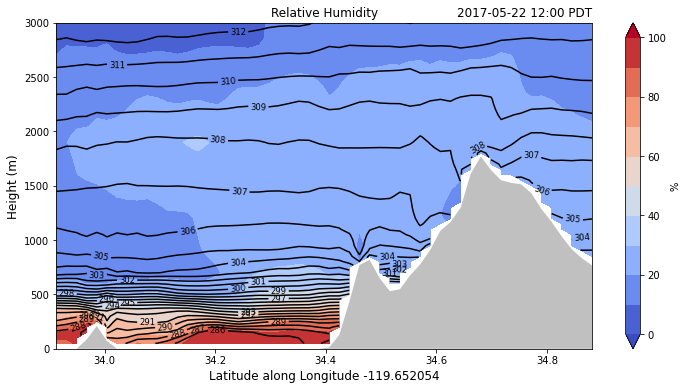

File saved as: /home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/plotting/outputs/figures/relative_humidity_2017_05_22_12.png 



In [19]:
# specify timestep
timestep = 12

# specify location of SYM and SRM labels and if you want them
labs_pos = [0.24, 0.1, 0.44, 0.35]
lab_key = False

# choose variable
var_no = 2
varz = ['va', 'wa', 'rh']
var_units = [ "m s-1", "m s-1", "%"]
var_names = ['merd_velocity', 'vertical_velocity', 'relative_humidity']
var_titles = ['Meridional Velocity', 'Vertical Velocity', 'Relative Humidity']

var_colors = ['PuOr', 'PuOr', 'coolwarm']
var_levels = [np.arange(-20, 21, 1), np.arange(-4, 5, 1), np.arange(0, 110, 10)]

var = varz[var_no]
var_unit = var_units[var_no]

var_name = var_names[var_no]
var_title = var_titles[var_no]
var_color = var_colors[var_no]
levels = var_levels[var_no]

# choose colorbar levels for theta
dmax = np.ceil(np.nanmax(data['theta'].values))
dmin = np.floor(np.nanmin(data['theta'].values))
levelst = np.arange(dmin, dmax + 1, 1)
    
plot_cross_section(cross_data[var].sel(Time = timestep), \
                   cross_data['theta'].sel(Time = timestep), \
                   cross_data['terr'], levels, levelst, var_color, var_unit, \
                    var_title, var_name, fig_outdir, [], [], 3000, lab_key, labs_pos)

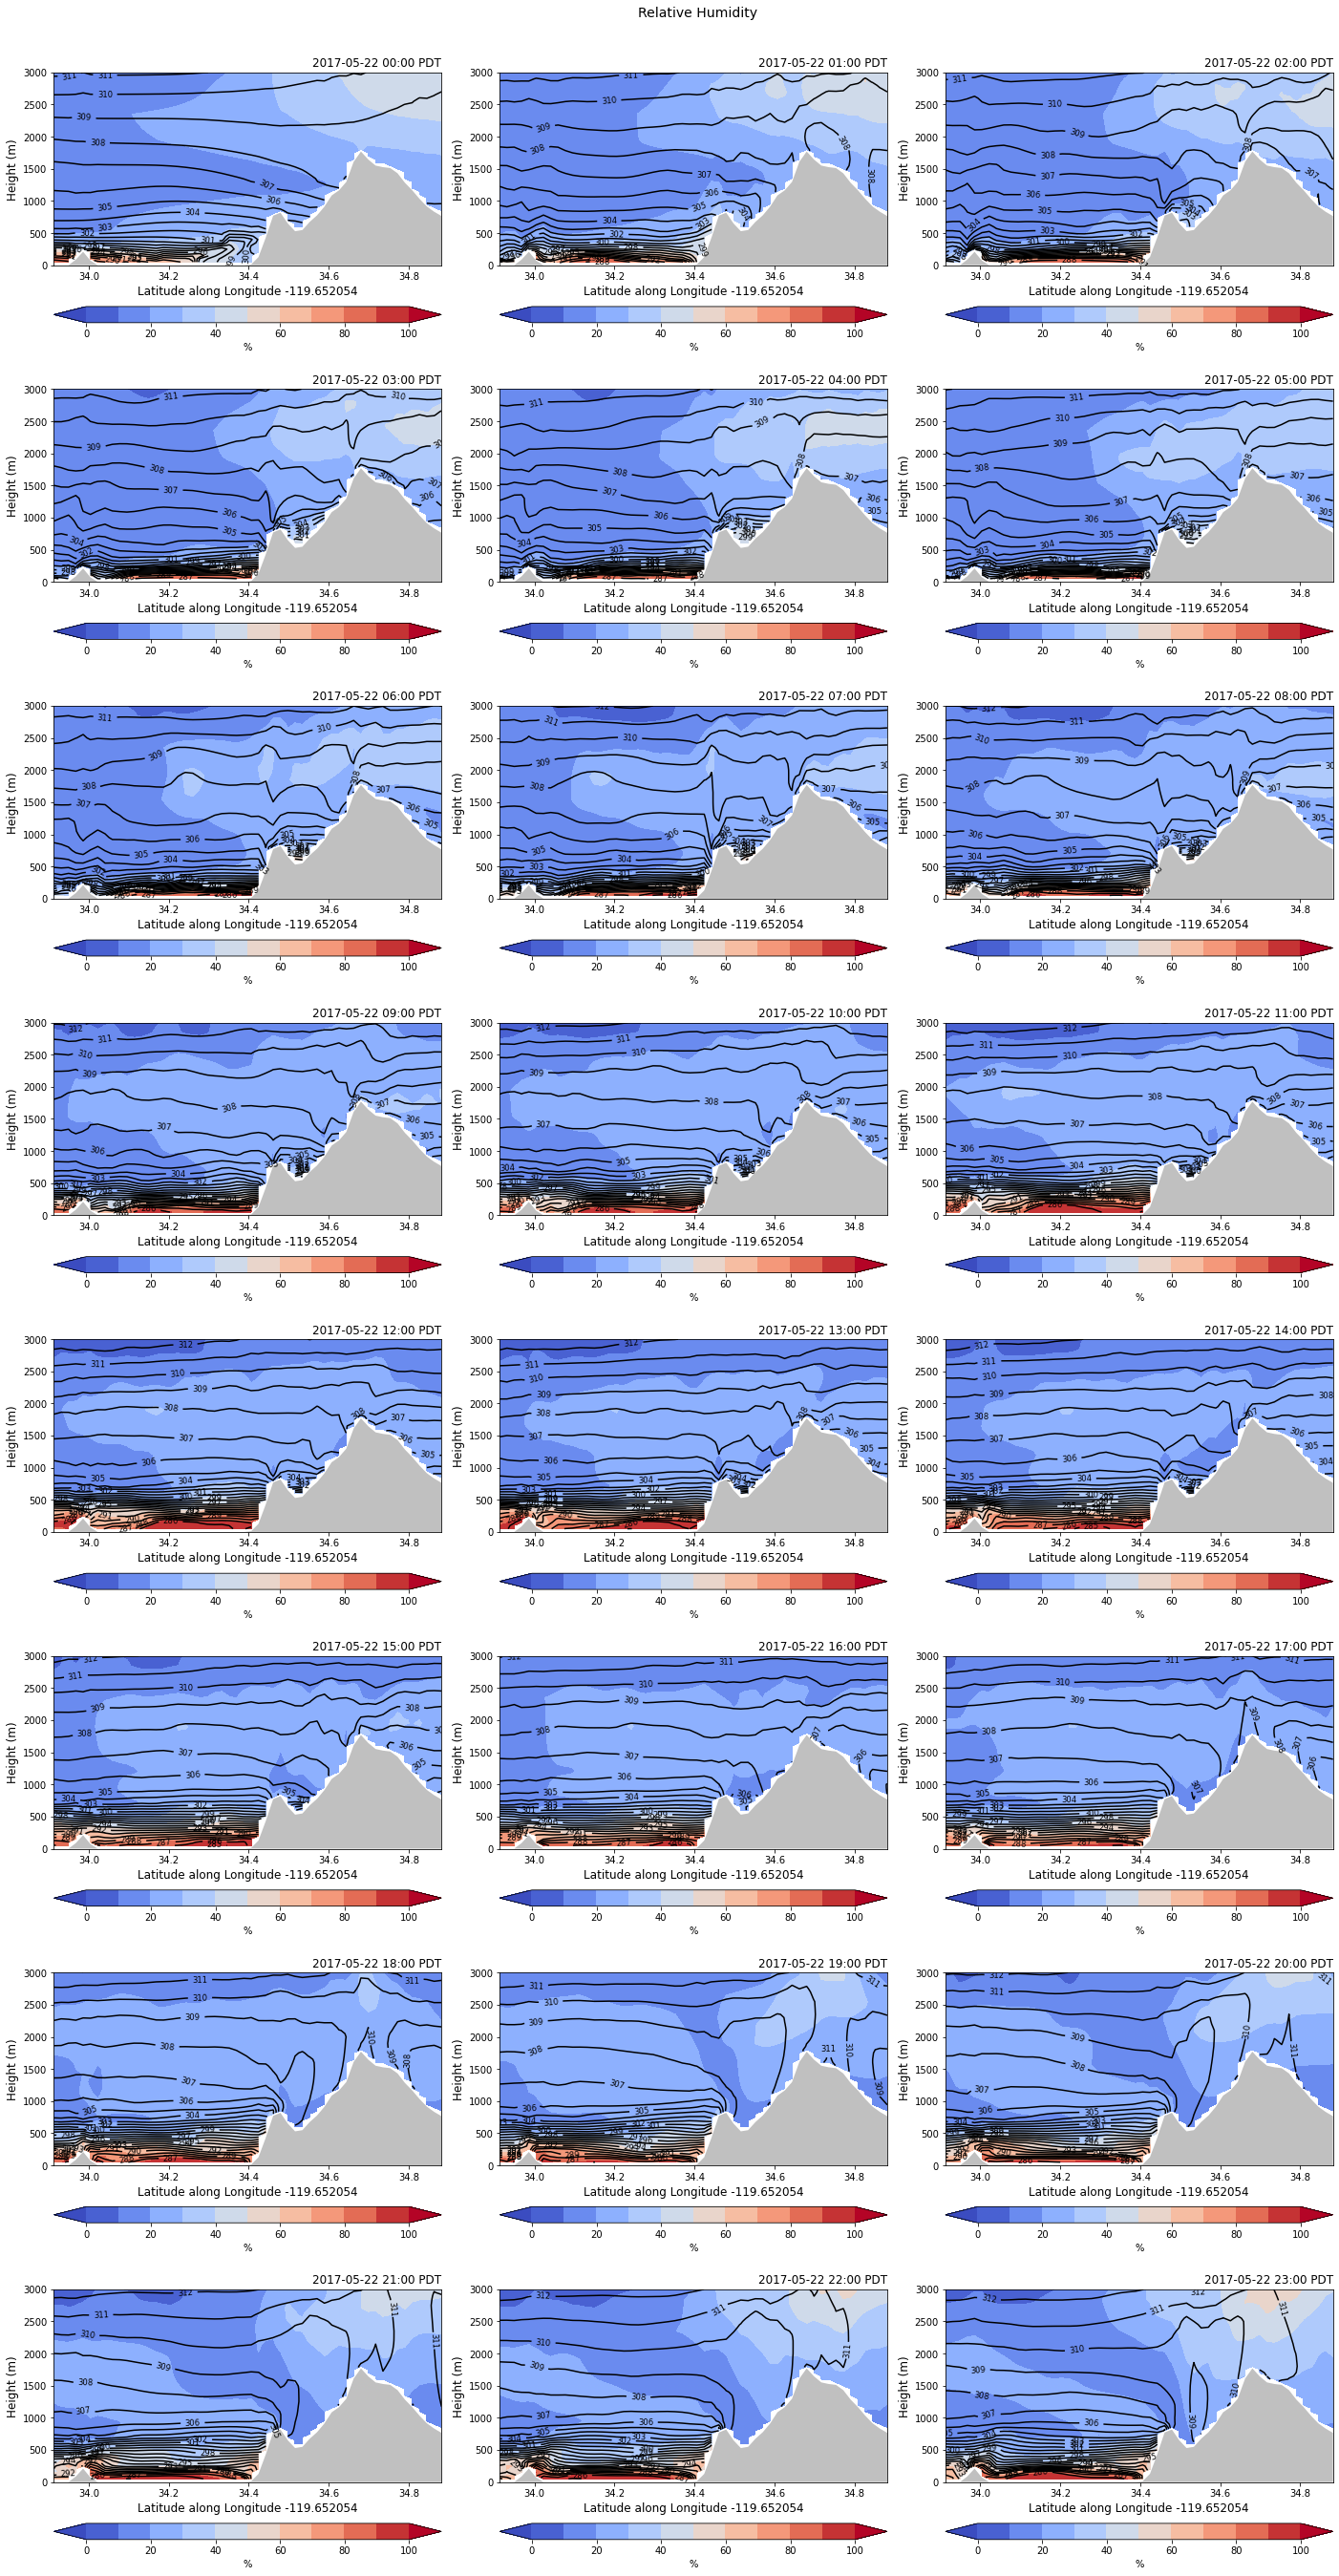

File saved as: /home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/plotting/outputs/figures/relative_humidity_2017-05-22_00_00_to_2017-05-22_23_00.png 



In [31]:
# des_hours = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
des_hours = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
dur = len(des_hours)

# set up subsfigure rows and columns
nc = 3
nr = int(dur/nc)

for i in range(0, len(data.time.values), 24):

    xsection_subplots(cross_data['theta'][i:i+24], cross_data[var][i:i+24], cross_data['terr'], levelst, levels, var_color, \
                      var_unit, var_title, var_name, fig_outdir, int(nc * 8), \
                      int(nr * 6), [0.15, 0.15], nr, nc, des_hours, dur, 0.9, 0.09, True, 3000)